# Optimize Profile Lengths

The goal of this project was to solve a real business problem in the field of Industrial Engineering. In times of high material prices and poor material availability, it is very important to keep waste as low as possible. The use of suitable profile lengths plays a major role in the metalworking industry. For this reason, extruded profiles are stored in different lengths in order to select the version with the least waste for the specific order. The waste is created by cutting it down to the required level.

One approach to calculate the fitting profile lengths is to analyze data from previous orders and calculate which lengths would have resulted in the least amount of material being used. An increase in the number of lengths stored leads to an ever-increasing reduction in scrap. However, as the number of combinations increases, it becomes more and more difficult to calculate the optimum. Automated algorithms come into play at this point. Here I would like to introduce a simple solution.

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools 

The original data was loaded in csv format from a production database and needed some cleaning (commented-out code). For our project, however, we use randomly generated data with a similar distribution that is left-skeewed. More precisely most orders are shortly before the maximum possible configuration, but drop again in the direction of the maximum.

We have 2 columns. The first column contains the number of individual parts that have been sawn per order ("quantity"), and the second column contains the corresponding cutting dimensions ("z_value"). 

It should also be noted that in this practical example each order must be manufactured individually. Optimization over several orders is not possible.

In [39]:
#file = "data.csv"
#data = pd.read_csv(file, delimiter=";", names=["quantity","z_value"], header=0)
#data.iloc[:,1] = data.iloc[:,1].apply(lambda x: x.replace(".","").split(",", 1)[0].strip())
#data.iloc[:,1] = data.iloc[:,1].astype('int64')

In [40]:
np.random.seed(1)

z_value = list(map(int, np.random.triangular(1800, 4000, 4500, 1000)))
quantity = list(map(int, np.random.triangular(5, 24, 27, 1000)))

data_dict = {"quantity":quantity,"z_value":z_value}
data = pd.DataFrame(data_dict)
data.head()

,quantity,z_value
0,16,3373
1,24,3868
2,22,1826
3,22,3140
4,19,2733


In [41]:
data.iloc[:,1].describe()

count    1000.000000
mean     3431.657000
std       591.563856
min      1826.000000
25%      3022.750000
50%      3535.500000
75%      3911.000000
max      4439.000000
Name: z_value, dtype: float64

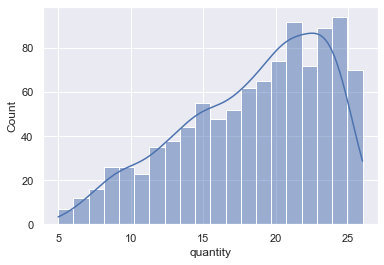

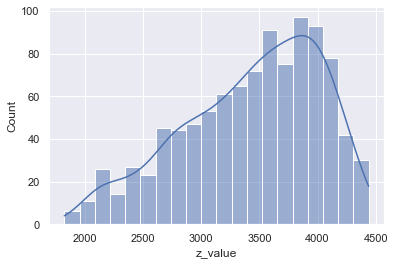

In [42]:
sns.set(style="darkgrid")

sns.histplot(data=data, x="quantity", bins=20, kde=True)
plt.show()

sns.histplot(data=data, x="z_value", bins=20, kde=True)
plt.show()

Our random generated data has 1000 entries. The cut size is moving between 1826 and 4439 mm with a mean of 3431 mm.

In the next step we set all variables that are necessary to limit the analysis and define the its goal:
- cut_part [mm]: First you have to determine the size of the part, which always has to be sawn off due to a first cut. This is necessary to trim the ends and create a vertical surface. The width of the saw blade must also be taken into account. In our case, 50 mm was a usual value.
- min_limit/max_limit [mm]: It is possible to set a minimum and maximum value for the calculated profile lengts. Here we choose 3000 and 6000 mm, because the paint shop cannot hang up shorter profiles and longer parts are difficult to transport through production.
- max_number_len: This variable defines how many profile lengths the optimized combination should have. In order to compare different numbers, the code must be run several times with different values.
- initial_optimization_steps [mm]: The first loop of optimization is carried out with this value. In other words, the possible length range is divided into pieces with this value, from which the first combinations are formed.
- target_optimization_steps [mm]: The optimization loop stops as soon as profile lengths have been changed with this value.

In [43]:
cut_part = 50

min_limit = 3000
max_limit = 6000

max_number_len = 4

initial_optimization_steps = 500
target_optimization_steps = 10

In [44]:
# adding the cut part to the needed cutting length
data.iloc[:,1] = data.iloc[:,1] + cut_part

# round the shortest and longest profile length needed to produce all the jobs
min_len_profile = data.iloc[:,1].min() // target_optimization_steps * target_optimization_steps + target_optimization_steps
max_len_profile = (data.iloc[:,1].max() + (target_optimization_steps -1)) // target_optimization_steps * target_optimization_steps

# set limits into account if not shorter then min_len_profile or max_len_profile
start_len = max(min_len_profile, min_limit)
end_len = max(max_len_profile+1, max_limit+1)

current_optimization_steps = initial_optimization_steps

# divide possible range by initial_optimization_steps and create a list of it
test_lenghts = np.arange(start_len, end_len, current_optimization_steps).tolist()

# add the max_limit length to the list, if it is not already included
if end_len-1 not in test_lenghts:
    test_lenghts.append(end_len-1)

print("initial profile lengths to test", test_lenghts)

initial profile lengths to test [3000, 3500, 4000, 4500, 5000, 5500, 6000]


The functions required for the analysis are described below. They make it easier to create a loop.

The first function "new_comb" generates combinations of "max_number_len" lengths from the "test_lengths".

In [45]:
def new_comb(test_lenghts, max_number_len, max_len_profile):

    profile_comb = list(itertools.combinations(test_lenghts,max_number_len))

    possible_profile_comb = profile_comb.copy()

    # remove combinations that do not have a lenght to cover up the max_len_profile
    for comb in profile_comb:
        if max(comb) < max_len_profile:
            possible_profile_comb.remove(comb)
    
    return possible_profile_comb

The function "data_comb" combines the generated combinations with our data. Each combination gets its own column in the dataframe. With "choose_len" the lenght with the least amount of waste is chosen for every row in data and all given combinations. It also considers that it could be better to cut more than one part out of a profile length even when the chosen length could have been shorter.

In [46]:
def data_comb(data, possible_profile_comb):

    data_combinations = data.copy()

    for comb in possible_profile_comb:
        data_combinations[comb] = data_combinations.apply(lambda row: choose_len(row[1], comb), axis=1)

    return data_combinations

In [47]:
def choose_len(z, comb):
    
    # start with highest value
    best_residual = max(comb)
    selected = max(comb)
    
    # iterate over all lengths in a combination
    for length in comb:
        if z <= length:
            residual = length % z
            if residual < best_residual:
                best_residual = residual
                selected = length
                
    return selected

The function "combination_results" calculates demand, consumption and waste for every given combination.

In [48]:
def combination_results(data_combinations, possible_profile_comb):

    combination_results = pd.DataFrame(possible_profile_comb)
    combination_results["demand"] = (data_combinations.iloc[:,0] * data_combinations.iloc[:,1]).sum() 
    
    combination_results["consumption"] = 0
    for i in range(len(data_combinations.columns)-2):
        # check how much profiles needed to cut the needed number of parts for the order
        number_profiles = data_combinations.iloc[:,0] / (data_combinations.iloc[:,i+2] / data_combinations.iloc[:,1]).apply(lambda x: int(x))
        combination_results.loc[i,"consumption"] = (number_profiles * data_combinations.iloc[:,i+2]).sum().round(0)

    combination_results["waste"] = combination_results["consumption"] - combination_results["demand"]
    combination_results_sorted = combination_results.sort_values(by=["waste"])
    
    return combination_results_sorted

To reduce the amount of combinations and thus primarily the computational effort the function "top_profile_lengths" only takes the top three combination from the current loop to generate a new list of the best test lengths. This list will be expanded by values which are half the size of the current optimization step away from the lengths. This brings you closer to the target_optimization_steps with each loop. The newly generated list is the input for the next run of the optimization.

In [49]:
def top_profile_lengths (combination_results_sorted, current_optimization_steps, max_limit, min_limit):

    unique_top_lengths = []

    # generate a list of the lengths of the top 3 combinations
    for i in range(len(combination_results_sorted.columns)-3):
        unique_top_lengths.append(set(combination_results_sorted.iloc[:3,i]))

    unique_top_lengths = set(itertools.chain.from_iterable(unique_top_lengths))
    
    # divide optimization_steps in half for the next loop
    current_optimization_steps = current_optimization_steps / 2 // target_optimization_steps * target_optimization_steps
    
    # when current_optimization_steps is lower than target_optimization_steps, set it to target_optimization_steps
    if current_optimization_steps / 2 < target_optimization_steps:
        current_optimization_steps = target_optimization_steps

    test_lenghts = []
    
    # adding values which are the current optimization step away from the lengths, but don't exceed the limits
    for length in unique_top_lengths:
        test_lenghts.append(length)
        if length + current_optimization_steps <= max_limit:
            test_lenghts.append(length + current_optimization_steps)  
        if length - current_optimization_steps > min_limit:
            test_lenghts.append(length - current_optimization_steps)
    
    test_lenghts = set(test_lenghts)
    test_lenghts = list(test_lenghts)
    test_lenghts.sort()

    return test_lenghts, current_optimization_steps

Loop through the function until target_optimization_steps is reached.

In [50]:
evaluation_data = pd.DataFrame()

iteration_step = 0

target_step_reached = False

while target_step_reached == False:
    
    iteration_step += 1
    print("Iteration step", iteration_step, "running")
    
    if current_optimization_steps == target_optimization_steps:
        target_step_reached = True

    possible_profile_comb = new_comb(test_lenghts, max_number_len, max_len_profile)
    print(len(possible_profile_comb), "combinations to examine")
    data_combinations = data_comb(data, possible_profile_comb)
    combination_results_sorted = combination_results(data_combinations, possible_profile_comb)
    test_lenghts, current_optimization_steps = top_profile_lengths (combination_results_sorted, current_optimization_steps, max_limit, min_limit)
    
    # add best combination of the iteration to a new dataframe
    evaluation_data = pd.concat([evaluation_data, combination_results_sorted.iloc[0,]], axis=1)
    print("Iteration step", iteration_step, "finished")

Iteration step 1 running
35 combinations to examine
Iteration step 1 finished
Iteration step 2 running
480 combinations to examine
Iteration step 2 finished
Iteration step 3 running
3480 combinations to examine
Iteration step 3 finished
Iteration step 4 running
819 combinations to examine
Iteration step 4 finished
Iteration step 5 running
819 combinations to examine
Iteration step 5 finished
Iteration step 6 running
2925 combinations to examine
Iteration step 6 finished


It's time to look at the results. 

In [51]:
# index of the best combination in the dataframe for further analysis
index_best_comb = evaluation_data.columns[-1]

# rename index from 1 to number of iterations
evaluation_data.columns = np.arange(1,len(evaluation_data.columns)+1)
# transponse the table for further analysis
evaluation_data_transponsed = evaluation_data.T

print(evaluation_data_transponsed)

        0       1       2       3      demand  consumption      waste
1  3000.0  3500.0  4000.0  4500.0  64209558.0   68930000.0  4720442.0
2  3000.0  3500.0  4000.0  4500.0  64209558.0   68930000.0  4720442.0
3  3120.0  3620.0  4120.0  4500.0  64209558.0   68897480.0  4687922.0
4  3120.0  3680.0  4060.0  4500.0  64209558.0   68843200.0  4633642.0
5  3030.0  3620.0  4060.0  4500.0  64209558.0   68828180.0  4618622.0
6  3030.0  3620.0  4040.0  4490.0  64209558.0   68781050.0  4571492.0


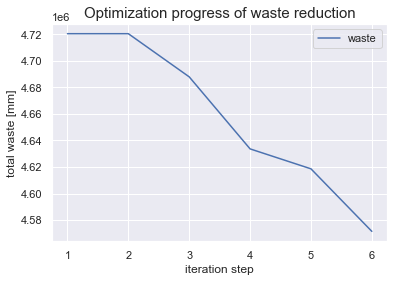

In [52]:
sns.set(style="darkgrid")
ax = sns.lineplot(data=evaluation_data_transponsed[["waste"]])
ax.set_title("Optimization progress of waste reduction", fontsize = 15)
ax.set(xlabel='iteration step', ylabel='total waste [mm]')
ax.set_xticks(range(1,len(evaluation_data.columns)+1), labels=range(1,len(evaluation_data.columns)+1))
plt.show()

With every iteration step the waste could be reduced. The best combination of 4 profile lengths is 3030, 3620, 4040 and 4490 mm.

In [53]:
data_best_comb = data_combinations.iloc[:,[0,1,index_best_comb+2]]
data_best_comb.head()

,quantity,z_value,"(3030.0, 3620.0, 4040.0, 4490.0)"
0,16,3423,3620.0
1,24,3918,4040.0
2,22,1876,4040.0
3,22,3190,3620.0
4,19,2783,3030.0


In [54]:
frequency_table = data_best_comb.iloc[:,-1].value_counts()

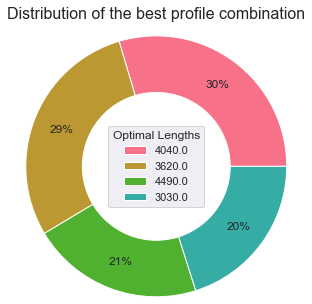

In [57]:
# pie Chart
plt.pie(frequency_table,  autopct='%.0f%%', pctdistance=0.78, colors=sns.color_palette("husl"), radius=1.5)
  
# draw circle
centre_circle = plt.Circle((0, 0), .85, fc='white')
fig = plt.gcf()

# adding Circle in Pie chart
fig.gca().add_artist(centre_circle)

# adding legend
plt.legend(frequency_table.index, title="Optimal Lengths", loc=10)

plt.title("Distribution of the best profile combination", fontsize = 15, y=1.15)
plt.show()

The 4 lengths are distrubuted very evenly, so it can be assumed that it is worthwhile to use them. It should be tested whether additional lengths make sense.

## Conclusions

The algorithm could satisfactorily solve the actual real business problem. In this case it was sufficient to calculate 2 to 4 different lengths.

However, it was noticeable that the calculation of combinations of more than 4 lengths and small iteration steps takes a long time, since several thousand possibilities have to be checked. To improve this, a first step could be to reduce the number of lengths to be considered as the optimization progresses. From a certain point it may be enough to improve only the current best combination. Another idea would be to eliminate possible lengths that are very close to each other or to combine them into an average. The size of the order data could be also reduced by sampling.